# Split Learning with SplitGuard detection 

The method is proposed in paper <SplitGuard: Detecting and Mitigating Training-Hijacking Attacks in Split Learning>.

## Initialization and model defination

In [1]:
import os

import matplotlib.pyplot as plt

import secretflow as sf

sf.shutdown()
sf.init(["alice", "bob"], address="local", num_cpus=6)
alice, bob = sf.PYU("alice"), sf.PYU("bob")
parties = [alice, bob]
import torch
from torch import nn as nn
from torch.nn import functional as F

from secretflow.ml.nn.utils import BaseModule


# The model structure is different from the original paper, thus there is defference in the hyper-parameters and results.
class ConvNetBase(BaseModule):
    """Small ConvNet basenet for cifar10."""

    def __init__(self):
        super(ConvNetBase, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(2, 2)
        # fully connected layer, output 10 classes
        self.out = nn.Linear(4 * 4 * 64, 500)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

    def output_num(self):
        return 1


class ConvNetFuse(BaseModule):
    """Small fusenet for cifar100."""

    def __init__(self):
        super(ConvNetFuse, self).__init__()
        self.fc1 = nn.Linear(500 * 2, 500)
        self.fc1act = nn.ReLU()
        self.fc2 = nn.Linear(500, 100)

    def forward(self, x):
        x = torch.cat(x, dim=1)
        x = x.view(-1, 1000)
        x = self.fc1(x)
        x = self.fc1act(x)
        x = self.fc2(x)
        return x

2023-10-21 18:15:48,414	INFO worker.py:1538 -- Started a local Ray instance.
2023-10-21 18:15:52.797526: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-21 18:15:52.797712: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-10-21 18:15:52.797731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Use label replace to compute the SG score(replace 7 batches out of 79 batches) 

In [2]:

import math
import os
import pickle
import random
import tempfile
from collections import namedtuple
from typing import Dict, List, Tuple, Union

import numpy as np
import torchvision
from torch import nn, optim
from torchmetrics import AUROC, Accuracy, Precision

from secretflow.data.ndarray import FedNdarray
from secretflow.device.device.pyu import PYU
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn.utils import TorchModel
from secretflow.utils.simulation.data.ndarray import create_ndarray
from slmodel_splitguard import SLModel_SG

_temp_dir = tempfile.mkdtemp()
NUM_CLASSES = 100
INPUT_SHAPE = (32, 32, 3)

fake_batch = []


def load_cifar100(
    parts_train: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    parts_test: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    normalized_x: bool = True,
    categorical_y: bool = False,
    is_torch: bool = False,
    batch_size: int = 32,
    N: int = 20,
    P_F: float = 0.1,
    B_F: int = 32,
) -> Tuple[Tuple[FedNdarray, FedNdarray], Tuple[FedNdarray, FedNdarray]]:
    x_train, y_train, x_test, y_test = [], [], [], []
    base_folder = "cifar-100-python"

    train_list = [
        ["train", "16019d7e3df5f24257cddd939b257f8d"],
    ]

    test_list = [
        ["test", "f0ef6b0ae62326f3e7ffdfab6717acfc"],
    ]
    cifar10_train = torchvision.datasets.CIFAR100(
        root="./data", train=True, download=True
    )
    cifar10_test = torchvision.datasets.CIFAR100(
        root="./data", train=False, download=True
    )
    for file_name, checksum in train_list:
        file_path = os.path.join("./data", base_folder, file_name)
        with open(file_path, "rb") as f:
            entry = pickle.load(f, encoding="latin1")
            x_train.append(entry["data"])
            if "labels" in entry:
                y_train.extend(entry["labels"])
            else:
                y_train.extend(entry["fine_labels"])

    x_train = np.vstack(x_train).reshape(-1, 3, 32, 32)
    y_train = np.array(y_train)
    for file_name, checksum in test_list:
        file_path = os.path.join("./data", base_folder, file_name)
        with open(file_path, "rb") as f:
            entry = pickle.load(f, encoding="latin1")
            x_test.append(entry["data"])
            if "labels" in entry:
                y_test.extend(entry["labels"])
            else:
                y_test.extend(entry["fine_labels"])

    x_test = np.vstack(x_test).reshape(-1, 3, 32, 32)
    y_test = np.array(y_test)

    # Set fake batches as paper.
    batch_num = len(y_train) // batch_size
    for i in range(batch_num):
        send_fakes = i > N and random.random() <= P_F
        if send_fakes and B_F > 0:
            index = random.sample(range(batch_size), B_F)
            index = [item + batch_size * i for item in index]
            for idx in index:
                y_train[idx] = (y_train[idx] + random.randint(1, 98)) % 100
            fake_batch.append(i)
    if normalized_x:
        x_train, x_test = x_train / 255, x_test / 255

    if categorical_y:
        from sklearn.preprocessing import OneHotEncoder

        encoder = OneHotEncoder(sparse=False)
        y_train = encoder.fit_transform(y_train.reshape(-1, 1))
        y_test = encoder.fit_transform(y_test.reshape(-1, 1))

    return (
        (
            create_ndarray(x_train, parts=parts_train, axis=0),
            create_ndarray(y_train, parts=parts_train, axis=0),
        ),
        (
            create_ndarray(x_test, parts=parts_test, axis=0),
            create_ndarray(y_test, parts=parts_test, axis=0),
        ),
    )


def create_dataset_builder(batch_size=32,):
    def dataset_builder(x):
        import pandas as pd
        import torch
        import torch.utils.data as torch_data

        x = [t.values if isinstance(t, pd.DataFrame) else t for t in x]
        x_copy = [torch.tensor(t.copy()) for t in x]
        data_set = torch_data.TensorDataset(*x_copy)
        dataloader = torch_data.DataLoader(dataset=data_set, batch_size=batch_size,)
        return dataloader

    return dataset_builder


def torch_model_with_cifar100(
    devices,
    base_model_dict,
    device_y,
    model_fuse,
    data_train,
    label_train,
    data_test,
    label_test,
    batch_size,
    N,
    alpha,
    beta,
    strategy="split_nn",
    backend="torch",
    **kwargs
):
    # kwargs parsing
    dp_strategy_dict = kwargs.get("dp_strategy_dict", None)
    compressor = kwargs.get("compressor", None)
    dataset_builder = kwargs.get("dataset_builder", None)

    base_local_steps = kwargs.get("base_local_steps", 1)
    fuse_local_steps = kwargs.get("fuse_local_steps", 1)
    bound_param = kwargs.get("bound_param", 0.0)

    loss_thres = kwargs.get("loss_thres", 0.01)
    split_steps = kwargs.get("split_steps", 1)
    max_fuse_local_steps = kwargs.get("max_fuse_local_steps", 10)

    # Define model class using modified class SLModel_SG
    sl_model = SLModel_SG(
        base_model_dict=base_model_dict,
        device_y=device_y,
        model_fuse=model_fuse,
        dp_strategy_dict=dp_strategy_dict,
        compressor=compressor,
        simulation=True,
        random_seed=1234,
        backend=backend,
        strategy=strategy,
        N=N,
        alpha=alpha,
        beta=beta,
        fake_batch=fake_batch,
        base_local_steps=base_local_steps,
        fuse_local_steps=fuse_local_steps,
        bound_param=bound_param,
        loss_thres=loss_thres,
        split_steps=split_steps,
        max_fuse_local_steps=max_fuse_local_steps,
    )
    # The fit() function is modified.
    history = sl_model.fit(
        data_train,
        label_train,
        validation_data=(data_test, label_test),
        epochs=5,
        batch_size=batch_size,
        shuffle=False,
        random_seed=1234,
        dataset_builder=dataset_builder,
    )
    global_metric = sl_model.evaluate(
        data_test,
        label_test,
        batch_size=batch_size,
        random_seed=1234,
        dataset_builder=dataset_builder,
    )

    # test history
    print(global_metric)
    print(history)
    assert math.isclose(
        global_metric["MulticlassAccuracy"],
        history["val_MulticlassAccuracy"][-1],
        rel_tol=0.01,
    )
    return sl_model.results, history["val_MulticlassAccuracy"][-1]

In [3]:
def test_torch_model(devices, batch_size, N, P_F, B_F, alpha, beta):
    alice = devices[0]
    bob = devices[1]
    num_samples_train = 50000
    num_samples_test = 10000
    (data_train, label_train), (data_test, label_test) = load_cifar100(
        parts_train={alice: (0, num_samples_train), bob: (0, num_samples_train),},
        parts_test={alice: (0, num_samples_test), bob: (0, num_samples_test),},
        normalized_x=True,
        categorical_y=True,
        is_torch=True,
        batch_size=batch_size,
        N=N,
        P_F=P_F,
        B_F=B_F,
    )
    data_train = data_train.astype(np.float32)
    label_train = label_train.astype(np.float32)
    data_test = data_test.astype(np.float32)
    label_test = label_test.astype(np.float32)
    loss_fn = nn.CrossEntropyLoss
    optim_fn = optim_wrapper(optim.Adam, lr=5e-4)
    base_model = TorchModel(
        model_fn=ConvNetBase,
        loss_fn=loss_fn,
        optim_fn=optim_fn,
        metrics=[
            metric_wrapper(
                Accuracy, task="multiclass", num_classes=100, average="micro"
            ),
            metric_wrapper(
                Precision, task="multiclass", num_classes=100, average="micro"
            ),
            metric_wrapper(AUROC, task="multiclass", num_classes=100),
        ],
    )

    fuse_model = TorchModel(
        model_fn=ConvNetFuse,
        loss_fn=loss_fn,
        optim_fn=optim_fn,
        metrics=[
            metric_wrapper(
                Accuracy, task="multiclass", num_classes=100, average="micro"
            ),
            metric_wrapper(
                Precision, task="multiclass", num_classes=100, average="micro"
            ),
            metric_wrapper(AUROC, task="multiclass", num_classes=100),
        ],
    )
    base_model_dict = {
        alice: base_model,
        bob: base_model,
    }

    # test dataset builder
    print("test Dataset builder")
    dataset_builder_dict = {
        alice: create_dataset_builder(batch_size=batch_size,),
        bob: create_dataset_builder(batch_size=batch_size,),
    }
    result, acc = torch_model_with_cifar100(
        devices=devices,
        base_model_dict=base_model_dict,
        device_y=bob,
        model_fuse=fuse_model,
        data_train=data_train,
        label_train=label_train,
        data_test=data_test,
        label_test=label_test,
        N=N,
        alpha=alpha,
        beta=beta,
        batch_size=batch_size,
        strategy="split_nn",
        backend="torch",
        dataset_builder=dataset_builder_dict,
    )
    return result, acc


Files already downloaded and verified
Files already downloaded and verified


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f9cac481880>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f9cac481c40>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f9cac481670>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f9cac481070>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f9ba9d83fd0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f9ba99ee1c0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNd

{'val_loss': array(2.7759588, dtype=float32), 'MulticlassAccuracy': tensor(0.2862), 'MulticlassPrecision': tensor(0.2862), 'MulticlassAUROC': tensor(0.9055)}
{'train_loss': [array(3.4553204, dtype=float32), array(2.6719904, dtype=float32), array(2.1670055, dtype=float32), array(1.755327, dtype=float32), array(1.4754087, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.0880), tensor(0.1763), tensor(0.2234), tensor(0.2548), tensor(0.2840)], 'train_MulticlassPrecision': [tensor(0.0880), tensor(0.1763), tensor(0.2234), tensor(0.2548), tensor(0.2840)], 'train_MulticlassAUROC': [tensor(0.7520), tensor(0.8302), tensor(0.8557), tensor(0.8714), tensor(0.8832)], 'val_val_loss': [array(3.5680366, dtype=float32), array(3.3181229, dtype=float32), array(3.0764985, dtype=float32), array(3.1524174, dtype=float32), array(2.7759588, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.1532), tensor(0.2136), tensor(0.2468), tensor(0.2725), tensor(0.2862)], 'val_MulticlassPrecision': [tensor(0.1532)

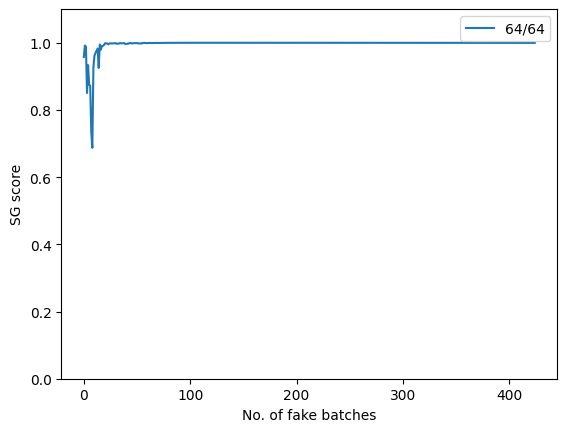

In [4]:

batch_size = 64
N = 20
P_F = 0.1
B_F = 64
alpha = 5
beta = 2
fake_batch = []
scores0, acc0 = test_torch_model(parties, batch_size, N, P_F, B_F, alpha, beta)

plt.plot(scores0, label="64/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")# xlabel means the index of fake batch in the total training.
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

Files already downloaded and verified
Files already downloaded and verified


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f9ba98ebee0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f9ba9bc4f40>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f9ba9bc40d0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f9bae901580>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f9ba9c303d0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f9ba9cecf70>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNd

{'val_loss': array(2.5866914, dtype=float32), 'MulticlassAccuracy': tensor(0.3373), 'MulticlassPrecision': tensor(0.3373), 'MulticlassAUROC': tensor(0.9291)}
{'train_loss': [array(3.1679475, dtype=float32), array(2.5819683, dtype=float32), array(1.9082667, dtype=float32), array(1.5525684, dtype=float32), array(1.3810265, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.1035), tensor(0.2143), tensor(0.2762), tensor(0.3196), tensor(0.3568)], 'train_MulticlassPrecision': [tensor(0.1035), tensor(0.2143), tensor(0.2762), tensor(0.3196), tensor(0.3568)], 'train_MulticlassAUROC': [tensor(0.7805), tensor(0.8705), tensor(0.8979), tensor(0.9134), tensor(0.9245)], 'val_val_loss': [array(3.3555048, dtype=float32), array(2.9858027, dtype=float32), array(2.691934, dtype=float32), array(2.6795022, dtype=float32), array(2.5866914, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.1901), tensor(0.2504), tensor(0.2990), tensor(0.3238), tensor(0.3373)], 'val_MulticlassPrecision': [tensor(0.1901)

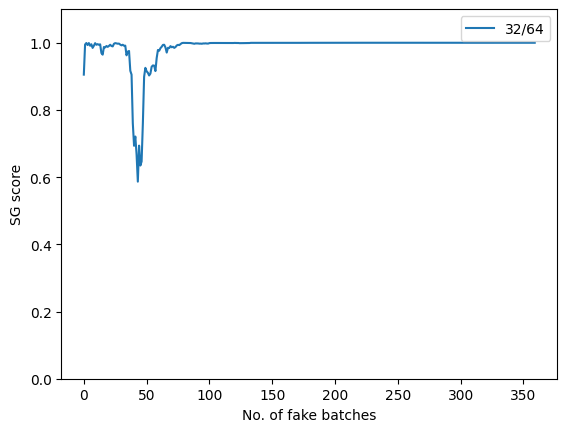

In [5]:
B_F = 32
fake_batch = []
scores1, acc1 = test_torch_model(parties, batch_size, N, P_F, B_F, alpha, beta)
plt.plot(scores1, label="32/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")# xlabel means the index of fake batch in the total training.
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()


Files already downloaded and verified
Files already downloaded and verified


(raylet) Spilled 4597 MiB, 9999 objects, write throughput 640 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 7385 MiB, 11999 objects, write throughput 836 MiB/s.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f9b29b24bb0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f9ba9bcea90>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f9b29b51ca0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f9b29b5ba90>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f9b29b40e20>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f9ba9bc8df0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNd

{'val_loss': array(2.5824537, dtype=float32), 'MulticlassAccuracy': tensor(0.3619), 'MulticlassPrecision': tensor(0.3619), 'MulticlassAUROC': tensor(0.9344)}
{'train_loss': [array(2.9990406, dtype=float32), array(2.2454758, dtype=float32), array(1.831285, dtype=float32), array(1.4264908, dtype=float32), array(1.1290343, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.1107), tensor(0.2247), tensor(0.2899), tensor(0.3384), tensor(0.3781)], 'train_MulticlassPrecision': [tensor(0.1107), tensor(0.2247), tensor(0.2899), tensor(0.3384), tensor(0.3781)], 'train_MulticlassAUROC': [tensor(0.7931), tensor(0.8833), tensor(0.9109), tensor(0.9263), tensor(0.9375)], 'val_val_loss': [array(3.2776022, dtype=float32), array(3.090159, dtype=float32), array(2.8300602, dtype=float32), array(2.6179457, dtype=float32), array(2.5824537, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.1912), tensor(0.2599), tensor(0.3037), tensor(0.3415), tensor(0.3619)], 'val_MulticlassPrecision': [tensor(0.1912),

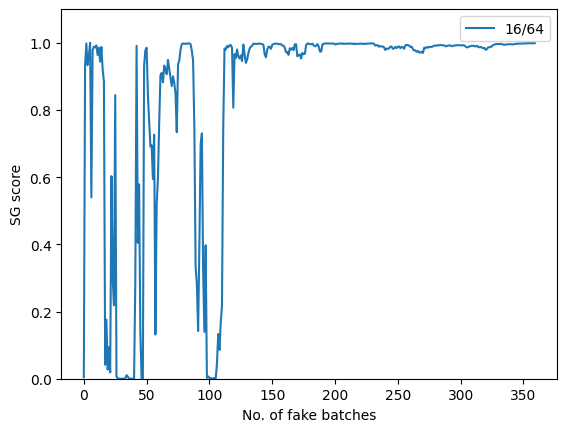

In [6]:
B_F = 16
fake_batch = []
scores2, acc2 = test_torch_model(parties, batch_size, N, P_F, B_F, alpha, beta)
plt.plot(scores2, label="16/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")# xlabel means the index of fake batch in the total training.
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()


Files already downloaded and verified
Files already downloaded and verified


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f9aa42fe070>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f9aa42fe100>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f9aa42fe400>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f9aa42fe3d0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f9aa42fe4f0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f9aa42fe520>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNd

{'val_loss': array(2.1151373, dtype=float32), 'MulticlassAccuracy': tensor(0.3771), 'MulticlassPrecision': tensor(0.3771), 'MulticlassAUROC': tensor(0.9412)}
{'train_loss': [array(3.0575209, dtype=float32), array(2.2754858, dtype=float32), array(1.798092, dtype=float32), array(1.3906015, dtype=float32), array(0.99697554, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.1159), tensor(0.2450), tensor(0.3153), tensor(0.3657), tensor(0.4075)], 'train_MulticlassPrecision': [tensor(0.1159), tensor(0.2450), tensor(0.3153), tensor(0.3657), tensor(0.4075)], 'train_MulticlassAUROC': [tensor(0.8051), tensor(0.8985), tensor(0.9259), tensor(0.9411), tensor(0.9519)], 'val_val_loss': [array(3.3099446, dtype=float32), array(2.8019204, dtype=float32), array(2.5064893, dtype=float32), array(2.2426212, dtype=float32), array(2.1151373, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.2033), tensor(0.2770), tensor(0.3250), tensor(0.3542), tensor(0.3771)], 'val_MulticlassPrecision': [tensor(0.2033

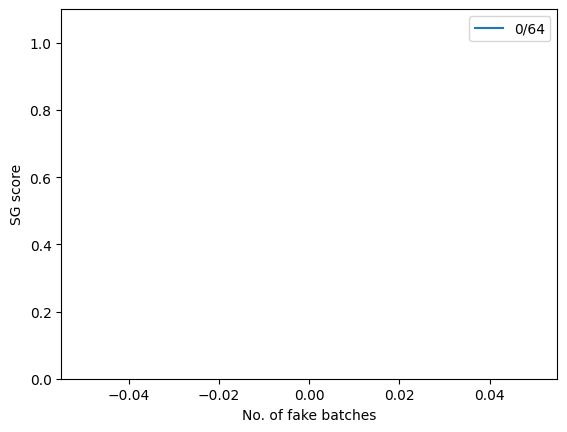

In [7]:
B_F = 0
fake_batch = []
scores3, acc3 = test_torch_model(parties, batch_size, N, P_F, B_F, alpha, beta)
plt.plot(scores3, label="0/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")# xlabel means the index of fake batch in the total training.
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

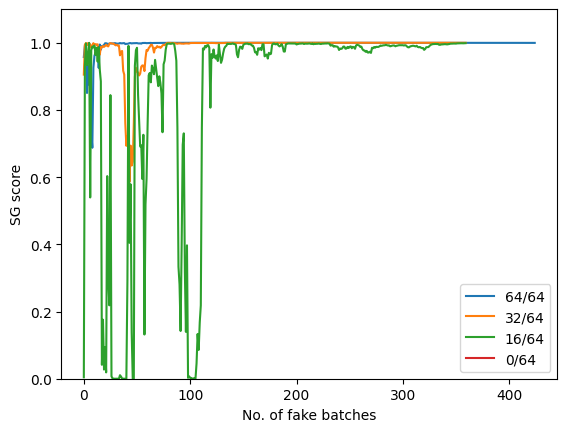

(raylet) [2023-10-21 20:56:26,304 E 59373 59473] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-21_18-15-45_658419_58933 is over 95% full, available space: 4770451456; capacity: 110111703040. Object creation will fail if spilling is required.
(raylet) [2023-10-21 20:56:36,314 E 59373 59473] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-21_18-15-45_658419_58933 is over 95% full, available space: 4770451456; capacity: 110111703040. Object creation will fail if spilling is required.
(raylet) [2023-10-21 20:56:46,322 E 59373 59473] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-21_18-15-45_658419_58933 is over 95% full, available space: 4770451456; capacity: 110111703040. Object creation will fail if spilling is required.
(raylet) [2023-10-21 20:56:56,333 E 59373 59473] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-21_18-15-45_658419_58933 is over 95% full, available space: 4770451456; capacity: 110111703040. Object creation wil

In [8]:
plt.plot(scores0, label="64/64")
plt.plot(scores1, label="32/64")
plt.plot(scores2, label="16/64")
plt.plot(scores3, label="0/64")

plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

In [9]:
print(
    "Test classification accuracy values for the CIFAR100 dataset for different B_F values with SplitGuard, with P_F=0.1"
)
print("BF=64, ACC=", acc0)
print("BF=32, ACC=", acc1)
print("BF=16, ACC=", acc2)
print("BF=0, ACC=", acc3)

Test classification accuracy values for the CIFAR100 dataset for different B_F values with SplitGuard, with P_F=0.1
BF=64, ACC= tensor(0.2862)
BF=32, ACC= tensor(0.3373)
BF=16, ACC= tensor(0.3619)
BF=0, ACC= tensor(0.3771)


(raylet) [2023-10-21 23:07:24,915 E 59373 59473] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-21_18-15-45_658419_58933 is over 95% full, available space: 4768546816; capacity: 110111703040. Object creation will fail if spilling is required.
(raylet) [2023-10-21 23:07:34,926 E 59373 59473] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-21_18-15-45_658419_58933 is over 95% full, available space: 4768546816; capacity: 110111703040. Object creation will fail if spilling is required.
(raylet) [2023-10-21 23:07:44,937 E 59373 59473] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-21_18-15-45_658419_58933 is over 95% full, available space: 4768546816; capacity: 110111703040. Object creation will fail if spilling is required.
(raylet) [2023-10-21 23:07:54,948 E 59373 59473] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-21_18-15-45_658419_58933 is over 95% full, available space: 4768546816; capacity: 110111703040. Object creation wil